# Replication

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import pickle
import time

import sys
sys.path.append(r"C:\Users\aleja\OneDrive\Documents\GitHub\Energy-Arbitrage\forecasters")
from models import model_dict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import io, requests
import xgboost as xgb
from sklearn.metrics import mean_absolute_error


# Pretrained Models

In [119]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import torch

from forecasters.models import model_dict  # uses models.py
# ------------------------------- SETTINGS ---------------------------------

MODEL_FOLDER = r"C:\Users\aleja\OneDrive\Documents\3-ProyectosARB\AI\battery_arbitrage_with_drl-master\forecasters\trained_models\cnn12hours"
DATA_PATH = r"C:\Users\aleja\OneDrive\Documents\3-ProyectosARB\AI\battery_arbitrage_with_drl-master\data\alberta3\ab_2018-2022_electricity_time_climate.csv"
TEST_YEAR = 2022

# ---------------------------- LOAD INPUT CONFIG ----------------------------

# Some Windows explorers hide extension → force add .json if needed
inputs_path = os.path.join(MODEL_FOLDER, "inputs")
if not inputs_path.endswith(".json"):
    inputs_path += ".json"

with open(inputs_path, "r") as f:
    config = json.load(f)

model_type = config["MODEL"]
horizon = config["EXP_PARAMS"]["HOURS_AHEAD"]
features = config["HYPERPARAMETERS"]["Features"]
target_col = config["HYPERPARAMETERS"]["Target_Column"]
window = config["HYPERPARAMETERS"]["WINDOW_SIZE"]

print("\n📌 Loaded pretrained model:")
print(f"🧠 Model: {model_type}")
print(f"🔁 Horizon: {horizon} hours ahead")
print(f"📏 Window size: {window}")
print(f"🧩 Features: {features}")
print(f"🎯 Target column: {target_col}")

# ---------------------------- LOAD TRAINED MODEL ---------------------------

from torch.nn import ReLU, Tanh, LeakyReLU   # to map from string

# Build architecture using saved hyperparameters
mp = config["HYPERPARAMETERS"]["model_params"]

# Convert activation name to torch nn.Module
activation_map = {"relu": ReLU(), "tanh": Tanh(), "leaky_relu": LeakyReLU()}
activation = activation_map.get(mp["activation"].lower(), ReLU())

ModelClass = model_dict[model_type]
model = ModelClass(
    in_dim=len(features),
    out_dim=1,
    window_size=mp["window_size"],
    activation=activation,
    cnn_net_shape=mp.get("cnn_net_shape", [32]),
    cnn_kernel_size=mp.get("cnn_kernel_size", 3),
    cnn_stride=mp.get("cnn_stride", 1),
    ann_net_shape=mp.get("ann_net_shape", [32])
)

# Load checkpoint
model_path = os.path.join(MODEL_FOLDER, "NN_params.pt")
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model.eval()




📌 Loaded pretrained model:
🧠 Model: CNN
🔁 Horizon: 12 hours ahead
📏 Window size: 22
🧩 Features: ['Actual Posted Pool Price', 'Actual AIL', 'cos_h', 'sin_h']
🎯 Target column: Actual Posted Pool Price


CNN(
  (cnn): Sequential(
    (0): Conv1d(4, 64, kernel_size=(1,), stride=(2,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(64, 64, kernel_size=(1,), stride=(2,))
    (3): LeakyReLU(negative_slope=0.01)
  )
  (ann): Sequential(
    (0): Linear(in_features=384, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
# ----------------------------- LOAD SCALERS --------------------------------

x_scaler = pickle.load(open(os.path.join(MODEL_FOLDER, "scaler.pkl"), "rb"))
y_scaler = None
target_scaler_path = os.path.join(MODEL_FOLDER, "target_scaler.pkl")
if os.path.exists(target_scaler_path):
    y_scaler = pickle.load(open(target_scaler_path, "rb"))

# ------------------------------- LOAD DATA ---------------------------------

df = pd.read_csv(DATA_PATH)
df["datetime"] = pd.to_datetime(df["Date"])
df = df[df["datetime"].dt.year == TEST_YEAR].reset_index(drop=True)
#df = df[features + [target_col]].dropna()

# ------------------------------ SCALE X ------------------------------------

# Scale only the real-valued columns the model scaler was fit on
cols_to_scale = config["HYPERPARAMETERS"]["Columns_to_scale"]

df_scaled = df.copy()
df_scaled[cols_to_scale] = x_scaler.transform(df[cols_to_scale])

df["Actual Posted Pool Price"].describe()

c:\Users\aleja\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\aleja\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


count    8760.000000
mean      162.572747
std       199.395252
min         0.000000
25%        62.677500
50%        83.780000
75%       141.087500
max       999.990000
Name: Actual Posted Pool Price, dtype: float64

In [114]:
# --------------------------- BUILD WINDOWS ---------------------------------

def build_windows(df_scaled, df_original, window, horizon):
    X, y = [], []
    for i in range(window, len(df_scaled) - horizon):
        X.append(df_scaled.iloc[i-window:i][features].values)
        y.append(df_original.iloc[i + horizon][target_col])
    return np.array(X), np.array(y)

X, y_true = build_windows(df_scaled, df, window, horizon)

# ------------------------------- PREDICT -----------------------------------

X_t = torch.tensor(X, dtype=torch.float32)

with torch.no_grad():
    y_pred = model(X_t).numpy().flatten()

# If target was scaled, inverse-transform
if y_scaler is not None:
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# ------------------------------- Metrics --------------------------------------

rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
print(f"\n🎯 RMSE on {TEST_YEAR}: {rmse:.3f}")

# Mean Absolute Error
mae = np.mean(np.abs(y_true - y_pred))

# Mean Absolute Percentage Error (avoid division by zero)
safe_mask = np.abs(y_true) > 1e-6
mape = np.mean(np.abs((y_true[safe_mask] - y_pred[safe_mask]) / y_true[safe_mask])) * 100

# Median Absolute Percentage Error
mdape = np.median(np.abs((y_true[safe_mask] - y_pred[safe_mask]) / y_true[safe_mask])) * 100

# R² score
ss_res = np.sum((y_true - y_pred) ** 2)
ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
r2 = 1 - ss_res / ss_tot

print(f"📌 MAE : {mae:.3f}")
print(f"📌 MAPE : {mape:.2f}%")
print(f"📌 MdAPE : {mdape:.2f}%")
print(f"📌 R² : {r2:.3f}\n")


🎯 RMSE on 2022: 171.579
📌 MAE : 91.737
📌 MAPE : 58.40%
📌 MdAPE : 38.02%
📌 R² : 0.260



## Figure 5

C:\Users\aleja\AppData\Local\Temp\ipykernel_24776\1022738282.py:42: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
c:\Users\aleja\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


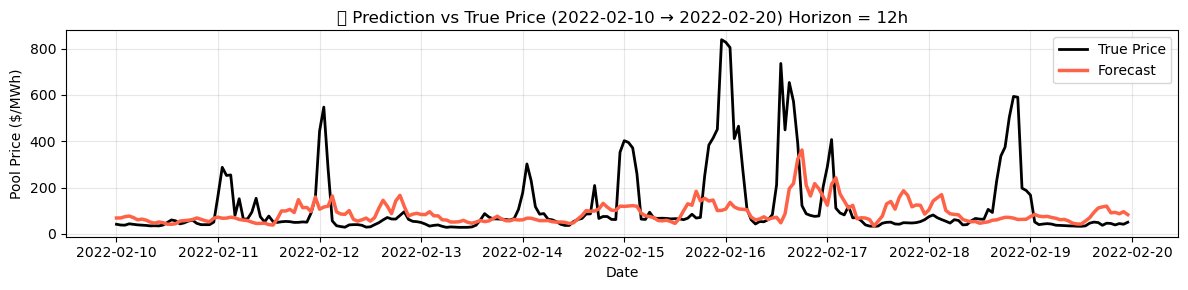

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ CREATE PREDICTION DATAFRAME ------------------

# We need the timestamps corresponding to y_true / y_pred
# Predictions start after (window + horizon)
start_idx = window + horizon

timestamps = pd.to_datetime(df["datetime"].iloc[start_idx:]).dt.tz_localize(None)


df_pred = pd.DataFrame({
    "datetime": timestamps,
    "y_true": y_true,
    "y_pred": y_pred
})

# Remove any negative misaligned indices just in case
df_pred = df_pred.dropna().reset_index(drop=True)

# ---------------------- SLICE BY DATE ----------------------

start_date = "2022-02-10"              # 👈 CHANGE HERE
end_date   = "2022-02-20"              # 👈 CHANGE HERE

mask = (df_pred["datetime"] >= pd.to_datetime(start_date)) & \
       (df_pred["datetime"] <  pd.to_datetime(end_date))

df_plot = df_pred.loc[mask].reset_index(drop=True)

# ---------------------------- PLOT -----------------------------

plt.figure(figsize=(12,3))
plt.plot(df_plot["datetime"], df_plot["y_true"], label="True Price", color="black", linewidth=2)
plt.plot(df_plot["datetime"], df_plot["y_pred"], label="Forecast", color="tomato", linewidth=2.5)
plt.title(f" Prediction vs True Price ({start_date} → {end_date}) Horizon = {horizon}h")
plt.xlabel("Date")
plt.ylabel("Pool Price ($/MWh)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 2. Replicate training phase (CNN3h)
## Original CNN3


In [185]:
# ------------------------------- SETTINGS ---------------------------------

MODEL_FOLDER = r"C:\Users\aleja\OneDrive\Documents\3-ProyectosARB\AI\battery_arbitrage_with_drl-master\forecasters\trained_models\cnn3hours"
DATA_PATH = r"C:\Users\aleja\OneDrive\Documents\3-ProyectosARB\AI\battery_arbitrage_with_drl-master\data\alberta3\ab_2018-2022_electricity_time_climate.csv"
TEST_YEAR = 2022

# ---------------------------- LOAD INPUT CONFIG ----------------------------

# Some Windows explorers hide extension → force add .json if needed
inputs_path = os.path.join(MODEL_FOLDER, "inputs")
if not inputs_path.endswith(".json"):
    inputs_path += ".json"

with open(inputs_path, "r") as f:
    config = json.load(f)

model_type = config["MODEL"]
horizon = config["EXP_PARAMS"]["HOURS_AHEAD"]
features = config["HYPERPARAMETERS"]["Features"]
target_col = config["HYPERPARAMETERS"]["Target_Column"]
window = config["HYPERPARAMETERS"]["WINDOW_SIZE"]

print("\n📌 Loaded pretrained model:")
print(f"🧠 Model: {model_type}")
print(f"🔁 Horizon: {horizon} hours ahead")
print(f"📏 Window size: {window}")
print(f"🧩 Features: {features}")
print(f"🎯 Target column: {target_col}")

# ---------------------------- LOAD TRAINED MODEL ---------------------------

from torch.nn import ReLU, Tanh, LeakyReLU   # to map from string

# Build architecture using saved hyperparameters
mp = config["HYPERPARAMETERS"]["model_params"]

# Convert activation name to torch nn.Module
activation_map = {"relu": ReLU(), "tanh": Tanh(), "leaky_relu": LeakyReLU()}
activation = activation_map.get(mp["activation"].lower(), ReLU())

ModelClass = model_dict[model_type]
model = ModelClass(
    in_dim=len(features),
    out_dim=1,
    window_size=mp["window_size"],
    activation=activation,
    cnn_net_shape=mp.get("cnn_net_shape", [32]),
    cnn_kernel_size=mp.get("cnn_kernel_size", 3),
    cnn_stride=mp.get("cnn_stride", 1),
    ann_net_shape=mp.get("ann_net_shape", [32])
)

# Load checkpoint
model_path = os.path.join(MODEL_FOLDER, "NN_params.pt")
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model.eval()

# ----------------------------- LOAD SCALERS --------------------------------

x_scaler = pickle.load(open(os.path.join(MODEL_FOLDER, "scaler.pkl"), "rb"))
y_scaler = None
target_scaler_path = os.path.join(MODEL_FOLDER, "target_scaler.pkl")
if os.path.exists(target_scaler_path):
    y_scaler = pickle.load(open(target_scaler_path, "rb"))

# ------------------------------- LOAD DATA ---------------------------------

df = pd.read_csv(DATA_PATH)
df["datetime"] = pd.to_datetime(df["Date"])
df = df[df["datetime"].dt.year == TEST_YEAR].reset_index(drop=True)
#df = df[features + [target_col]].dropna()

# ------------------------------ SCALE X ------------------------------------

# Scale only the real-valued columns the model scaler was fit on
cols_to_scale = config["HYPERPARAMETERS"]["Columns_to_scale"]

df_scaled = df.copy()
df_scaled[cols_to_scale] = x_scaler.transform(df[cols_to_scale])

df["Actual Posted Pool Price"].describe()
# --------------------------- BUILD WINDOWS ---------------------------------

def build_windows(df_scaled, df_original, window, horizon):
    X, y = [], []
    for i in range(window, len(df_scaled) - horizon):
        X.append(df_scaled.iloc[i-window:i][features].values)
        y.append(df_original.iloc[i + horizon][target_col])
    return np.array(X), np.array(y)

X, y_true = build_windows(df_scaled, df, window, horizon)

# ------------------------------- PREDICT -----------------------------------

X_t = torch.tensor(X, dtype=torch.float32)

with torch.no_grad():
    y_pred = model(X_t).numpy().flatten()

# If target was scaled, inverse-transform
if y_scaler is not None:
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# ------------------------------- Metrics --------------------------------------

rmse = np.sqrt(np.mean((y_true[-6500:] - y_pred[-6500:]) ** 2))
print(f"\n🎯 RMSE on {TEST_YEAR}: {rmse:.3f}")

# Mean Absolute Error
mae = np.mean(np.abs(y_true[-6500:] - y_pred[-6500:]))

# Mean Absolute Percentage Error (avoid division by zero)
safe_mask = np.abs(y_true[-6500:]) > 1e-6
mape = np.mean(np.abs((y_true[-6500:][safe_mask] - y_pred[-6500:][safe_mask]) / y_true[-6500:][safe_mask])) * 100

# Median Absolute Percentage Error
mdape = np.median(np.abs((y_true[-6500:][safe_mask] - y_pred[-6500:][safe_mask]) / y_true[-6500:][safe_mask])) * 100

# R² score
ss_res = np.sum((y_true[-6500:] - y_pred[-6500:]) ** 2)
ss_tot = np.sum((y_true[-6500:] - np.mean(y_true[-6500:])) ** 2)
r2 = 1 - ss_res / ss_tot

print(f"📌 MAE : {mae:.3f}")
print(f"📌 MAPE : {mape:.2f}%")
print(f"📌 MdAPE : {mdape:.2f}%")
print(f"📌 R² : {r2:.3f}\n")


📌 Loaded pretrained model:
🧠 Model: CNN
🔁 Horizon: 3 hours ahead
📏 Window size: 35
🧩 Features: ['Actual Posted Pool Price', 'Actual AIL', 'cos_h', 'sin_h']
🎯 Target column: Actual Posted Pool Price


c:\Users\aleja\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\aleja\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(



🎯 RMSE on 2022: 165.172
📌 MAE : 92.392
📌 MAPE : 52.01%
📌 MdAPE : 33.05%
📌 R² : 0.423



In [184]:
len(y_true[-6500:])

6500

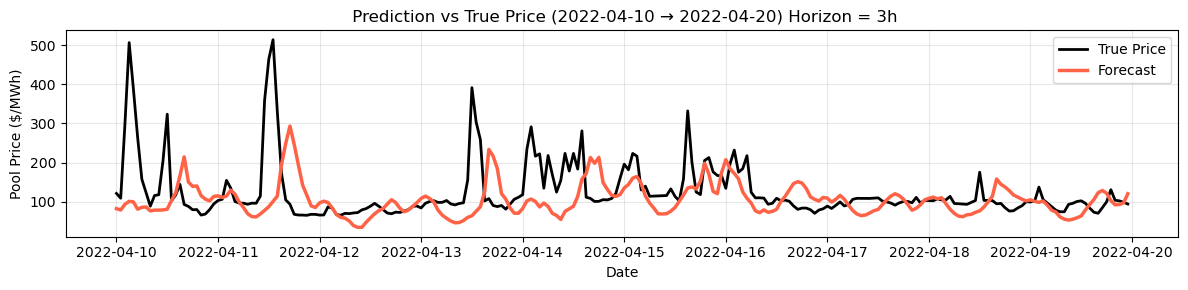

In [180]:

start_idx = len(df)-len(y_true)

timestamps = pd.to_datetime(df["datetime"].iloc[start_idx:]).dt.tz_localize(None)


df_pred = pd.DataFrame({
    "datetime": timestamps,
    "y_true": y_true,
    "y_pred": y_pred
})

# Remove any negative misaligned indices just in case
df_pred = df_pred.dropna().reset_index(drop=True)

# ---------------------- SLICE BY DATE ----------------------

start_date = "2022-04-10"              # 👈 CHANGE HERE
end_date   = "2022-04-20"              # 👈 CHANGE HERE

mask = (df_pred["datetime"] >= pd.to_datetime(start_date)) & \
       (df_pred["datetime"] <  pd.to_datetime(end_date))

df_plot = df_pred.loc[mask].reset_index(drop=True)

# ---------------------------- PLOT -----------------------------

plt.figure(figsize=(12,3))
plt.plot(df_plot["datetime"], df_plot["y_true"], label="True Price", color="black", linewidth=2)
plt.plot(df_plot["datetime"], df_plot["y_pred"], label="Forecast", color="tomato", linewidth=2.5)
plt.title(f" Prediction vs True Price ({start_date} → {end_date}) Horizon = {horizon}h")
plt.xlabel("Date")
plt.ylabel("Pool Price ($/MWh)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## New CNN3

Now that we have the model and metrics we want to replicate, lets train a new one.

In [127]:

# --------------------- USER SETTINGS ---------------------
DATA_PATH = r"C:\Users\aleja\OneDrive\Documents\3-ProyectosARB\AI\battery_arbitrage_with_drl-master\data\alberta3\ab_2018-2022_electricity_time_climate.csv"
TARGET_COL = "Actual Posted Pool Price"
COLS_TO_SCALE = ["Actual Posted Pool Price", "Actual AIL"]
FEATURES = ["Actual Posted Pool Price", "Actual AIL", "cos_h", "sin_h"]
HOURS_AHEAD = 3    # 👈 we will confirm from JSON
WINDOW = 41        # 👈 placeholder, will update from JSON
EPOCHS = 50        # we can increase later
LR = 0.001
BATCH_SIZE = 64

# ------------------------ LOAD DATA -----------------------
df = pd.read_csv(DATA_PATH)
df["datetime"] = pd.to_datetime(df["Date"]).dt.tz_localize(None)
#df = df[FEATURES + [TARGET_COL]].dropna()

# Train: until mid 2021 / Validation until end 2021 / Test 2022
train = df[df.index < int(len(df)*0.7)]
vali  = df[(df.index >= int(len(df)*0.7)) & (df.index < int(len(df)*0.85))]
test  = df[df.index >= int(len(df)*0.85)]

# ------------------------ SCALE ---------------------------
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler().fit(train[COLS_TO_SCALE])
y_scaler = MinMaxScaler().fit(train[[TARGET_COL]])

def scale_df(d):
    d = d.copy()
    d[COLS_TO_SCALE] = x_scaler.transform(d[COLS_TO_SCALE])
    return d

train_s, vali_s, test_s = scale_df(train), scale_df(vali), scale_df(test)



In [133]:


# -------------------- WINDOW MAKING ------------------------
def load_windows(df_scaled, df_true, window, horizon):
    X, y = [], []
    for i in range(window, len(df_scaled)-horizon):
        X.append(df_scaled.iloc[i-window:i][FEATURES].values)
        y.append(df_true.iloc[i+horizon][TARGET_COL])
    return np.array(X), np.array(y)

X_train, y_train = load_windows(train_s, train, window=WINDOW, horizon=HOURS_AHEAD)
X_vali,  y_vali  = load_windows(vali_s,  vali,  window=WINDOW, horizon=HOURS_AHEAD)
X_test,  y_test  = load_windows(test_s,  test,  window=WINDOW, horizon=HOURS_AHEAD)

# --------------------- TO TENSORS --------------------------
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_vali,  y_vali  = torch.tensor(X_vali,  dtype=torch.float32), torch.tensor(y_vali,  dtype=torch.float32).unsqueeze(1)
X_test,  y_test  = torch.tensor(X_test,  dtype=torch.float32), torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
vali_loader  = DataLoader(TensorDataset(X_vali, y_vali), batch_size=BATCH_SIZE)

# --------------------- MODEL CREATION -----------------------
# ⚠ parameters below will change once you paste JSON
model = model_dict["CNN"](in_dim=len(FEATURES), out_dim=1, window_size=WINDOW)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

# ------------------------ TRAINING --------------------------
best_val = float("inf")
for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        optimizer.step()

    # ---- validation ----
    model.eval()
    with torch.no_grad():
        val_loss = loss_fn(model(X_vali), y_vali).item()

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "cnn3_new.pt")  # save best

    print(f"Epoch {epoch+1}/{EPOCHS} ▸ Train Loss={loss.item():.4f} | Val={val_loss:.4f}")

print("\n✔ Training complete! Saved checkpoint → cnn3_new.pt")


Epoch 1/50 ▸ Train Loss=4769.1187 | Val=13031.1973
Epoch 2/50 ▸ Train Loss=971.7875 | Val=12688.9609
Epoch 3/50 ▸ Train Loss=7748.6514 | Val=12467.1768
Epoch 4/50 ▸ Train Loss=823.7145 | Val=11967.3008
Epoch 5/50 ▸ Train Loss=5727.2275 | Val=12020.6992
Epoch 6/50 ▸ Train Loss=9979.2949 | Val=11559.3398
Epoch 7/50 ▸ Train Loss=8695.8887 | Val=11546.3740
Epoch 8/50 ▸ Train Loss=526.8836 | Val=11866.7178
Epoch 9/50 ▸ Train Loss=3708.9231 | Val=11892.2441
Epoch 10/50 ▸ Train Loss=9842.3047 | Val=11282.1807
Epoch 11/50 ▸ Train Loss=2539.8030 | Val=11559.0703
Epoch 12/50 ▸ Train Loss=3035.5784 | Val=11531.3555
Epoch 13/50 ▸ Train Loss=4028.4224 | Val=11594.5723
Epoch 14/50 ▸ Train Loss=1020.3530 | Val=11994.5996
Epoch 15/50 ▸ Train Loss=4073.0444 | Val=11313.9170
Epoch 16/50 ▸ Train Loss=24873.2500 | Val=11395.3945
Epoch 17/50 ▸ Train Loss=2273.4719 | Val=11299.5527
Epoch 18/50 ▸ Train Loss=2054.0684 | Val=11502.0801
Epoch 19/50 ▸ Train Loss=2215.0762 | Val=11350.6182
Epoch 20/50 ▸ Train Los

In [230]:
# -------- LOAD BEST MODEL (already done) --------
model = model_dict["CNN"](in_dim=len(FEATURES), out_dim=1, window_size=WINDOW)

model.load_state_dict(torch.load("cnn3_new.pt", map_location=torch.device("cpu")))
model.eval()

# ---------------- PREDICT -----------------------
with torch.no_grad():
    y_hat = model(X_test).numpy().flatten()

y_pred = y_hat.copy() 
y_true = y_test.numpy().flatten()

def safe_mape(y_true, y_pred):
    mask = np.abs(y_true) > 1e-6
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def safe_mdape(y_true, y_pred):
    mask = np.abs(y_true) > 1e-6
    return np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
mae  = np.mean(np.abs(y_true - y_pred))
mape = safe_mape(y_true, y_pred)
mdape = safe_mdape(y_true, y_pred)

# R²
ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - np.mean(y_true))**2)
r2 = 1 - ss_res/ss_tot

print("\n📊 PERFORMANCE (Test Set, scaled back to $/MWh)")
print(f"RMSE  : {rmse:.3f}")
print(f"MAE   : {mae:.3f}")
print(f"MAPE  : {mape:.2f}%")
print(f"MdAPE : {mdape:.2f}%")
print(f"R²    : {r2:.3f}\n")



📊 PERFORMANCE (Test Set, scaled back to $/MWh)
RMSE  : 162.940
MAE   : 96.687
MAPE  : 61.33%
MdAPE : 39.57%
R²    : 0.436



In [231]:
y_true_cnn3=y_true.copy()
y_pred_cnn3=y_pred.copy()

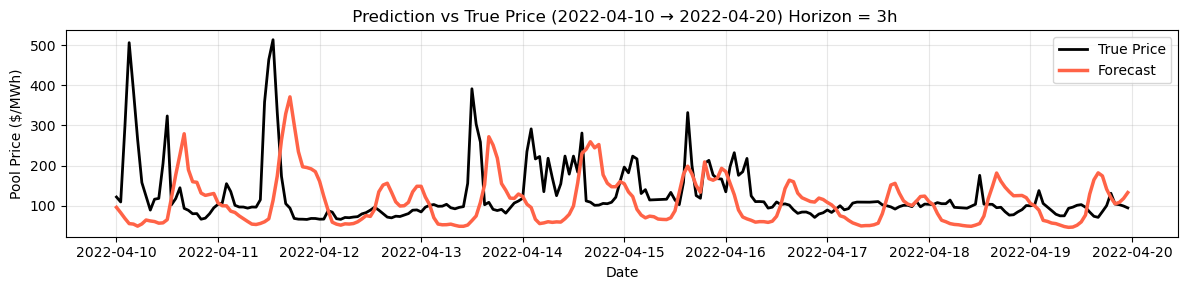

In [232]:

#start_idx = window + horizon

timestamps = pd.to_datetime(test["datetime"].iloc[38+6:]).dt.tz_localize(None)


df_pred = pd.DataFrame({
    "datetime": timestamps,
    "y_true": y_true_cnn3,
    "y_pred": y_pred_cnn3
})

# Remove any negative misaligned indices just in case
df_pred = df_pred.dropna().reset_index(drop=True)

# ---------------------- SLICE BY DATE ----------------------

start_date = "2022-04-10"              # 👈 CHANGE HERE
end_date   = "2022-04-20"              # 👈 CHANGE HERE

mask = (df_pred["datetime"] >= pd.to_datetime(start_date)) & \
       (df_pred["datetime"] <  pd.to_datetime(end_date))

df_plot = df_pred.loc[mask].reset_index(drop=True)

# ---------------------------- PLOT -----------------------------

plt.figure(figsize=(12,3))
plt.plot(df_plot["datetime"], df_plot["y_true"], label="True Price", color="black", linewidth=2)
plt.plot(df_plot["datetime"], df_plot["y_pred"], label="Forecast", color="tomato", linewidth=2.5)
plt.title(f" Prediction vs True Price ({start_date} → {end_date}) Horizon = {horizon}h")
plt.xlabel("Date")
plt.ylabel("Pool Price ($/MWh)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 3. Get a better model for same data

## AR 3

In [194]:
# Shift true values by 1 to create naive prediction
y_pred_lag = np.concatenate([[y_true[0],y_true[0],y_true[0]], y_true[:-3]])

# ---------- Metrics ----------
rmse_lag  = np.sqrt(np.mean((y_true - y_pred_lag)**2))
mae_lag   = np.mean(np.abs(y_true - y_pred_lag))

mask = np.abs(y_true) > 1e-6
mape_lag  = np.mean(np.abs((y_true[mask] - y_pred_lag[mask]) / y_true[mask])) * 100
mdape_lag = np.median(np.abs((y_true[mask] - y_pred_lag[mask]) / y_true[mask]) * 100)

ss_res = np.sum((y_true - y_pred_lag)**2)
ss_tot = np.sum((y_true - np.mean(y_true))**2)
r2_lag = 1 - ss_res / ss_tot

print("📌 Naive Lag (AR1)")
print(f"RMSE  : {rmse_lag:.3f}")
print(f"MAE   : {mae_lag:.3f}")
print(f"MAPE  : {mape_lag:.2f}%")
print(f"MdAPE : {mdape_lag:.2f}%")
print(f"R²    : {r2_lag:.3f}")


📌 Naive Lag (AR1)
RMSE  : 172.231
MAE   : 86.048
MAPE  : 59.19%
MdAPE : 23.63%
R²    : 0.255


## XGBoost

In [233]:
df = pd.read_csv(DATA_PATH)
df["datetime"] = pd.to_datetime(df["Date"]).dt.tz_localize(None)
df["price"]=df['Actual Posted Pool Price']

df["price_lag3"]=df["price"].shift(3)
df["price_lag12"]=df["price"].shift(12)
df["price_lag24"]=df["price"].shift(24)

split = int(len(df)*0.8)
train_df = df.iloc[:split]
test_df  = df.iloc[split:]

df.columns

Index(['Date', 'Date_local', 'Forecast Pool Price', 'Actual Posted Pool Price',
       'Forecast AIL', 'Actual AIL', 'Forecast AIL & Actual AIL Difference',
       'h', 'cos_h', 'sin_h', 'week', 'cos_w', 'sin_w', 'month', 'cos_m',
       'sin_m', 'longitude', 'latitude', 'u100', 'v100', 'u10', 'v10', 'd2m',
       't2m', 'sp', 'ssrd', 'tp', 'd2m_C', 't2m_C', 'rh', 'ws100', 'wdir',
       'datetime', 'price', 'price_lag3', 'price_lag12', 'price_lag24'],
      dtype='object')

In [234]:
feature_cols=["price_lag3",
              "price_lag12",
              "price_lag24", 'cos_h', 'sin_h']

model_ml = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=9,
    subsample=0.8,
    colsample_bytree=0.8
)
model_ml.fit(train_df[feature_cols], train_df["price"])

y_pred = model_ml.predict(test_df[feature_cols])
y_true = test_df["price"].values

# ---------- Metrics ----------
rmse  = np.sqrt(np.mean((y_true - y_pred)**2))
mae   = np.mean(np.abs(y_true - y_pred))

# Avoid divide by zero in MAPE
mask = np.abs(y_true) > 1e-6
mape  = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
mdape = np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]) * 100)

# Manual R² (same as sklearn)
ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - np.mean(y_true))**2)
r2_manual = 1 - ss_res / ss_tot

# ---------- Print ----------
print("📌 XGBoost Model Performance")
print(f"RMSE  : {rmse:.3f}")
print(f"MAE   : {mae:.3f}")
print(f"MAPE  : {mape:.2f}%")
print(f"MdAPE : {mdape:.2f}%")
print(f"R²    : {r2_manual:.3f}")


📌 XGBoost Model Performance
RMSE  : 150.139
MAE   : 84.039
MAPE  : 59.96%
MdAPE : 33.41%
R²    : 0.433


In [235]:
feature_cols=["price_lag3",
              "price_lag12",
              "price_lag24",'h', 'cos_h', 'sin_h', 'week', 'cos_w', 'sin_w', 'month', 'cos_m',
       'sin_m', 'longitude', 'latitude', 'u100', 'v100', 'u10', 'v10', 'd2m',
       't2m', 'sp', 'ssrd', 'tp', 'd2m_C', 't2m_C', 'rh', 'ws100', 'wdir']

model_ml = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=9,
    subsample=0.8,
    colsample_bytree=0.8
)
model_ml.fit(train_df[feature_cols], train_df["price"])

y_pred = model_ml.predict(test_df[feature_cols])
y_true = test_df["price"].values

# ---------- Metrics ----------
rmse  = np.sqrt(np.mean((y_true - y_pred)**2))
mae   = np.mean(np.abs(y_true - y_pred))

# Avoid divide by zero in MAPE
mask = np.abs(y_true) > 1e-6
mape  = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
mdape = np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]) * 100)

# Manual R² (same as sklearn)
ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - np.mean(y_true))**2)
r2_manual = 1 - ss_res / ss_tot

# ---------- Print ----------
print("📌 XGBoost Model Performance")
print(f"RMSE  : {rmse:.3f}")
print(f"MAE   : {mae:.3f}")
print(f"MAPE  : {mape:.2f}%")
print(f"MdAPE : {mdape:.2f}%")
print(f"R²    : {r2_manual:.3f}")

📌 XGBoost Model Performance
RMSE  : 152.355
MAE   : 82.898
MAPE  : 50.61%
MdAPE : 33.46%
R²    : 0.416


C:\Users\aleja\AppData\Local\Temp\ipykernel_24776\1763663102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["pred_xgb"] = y_pred[-6574:]  # 👈 add XGBoost predictions to test df


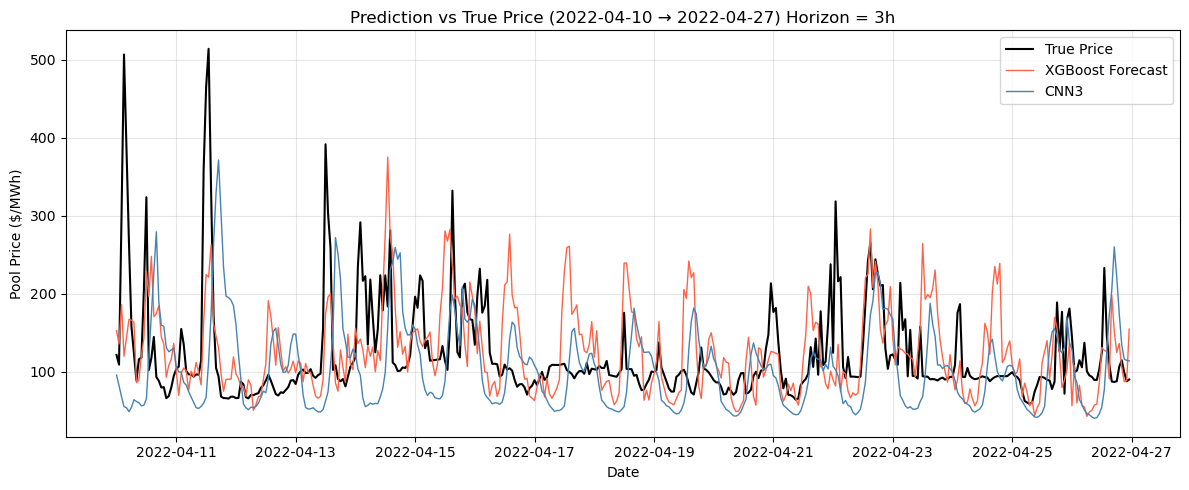

In [241]:
test["pred_xgb"] = y_pred[-6574:]  # 👈 add XGBoost predictions to test df
timestamps = pd.to_datetime(test["datetime"].iloc[38+6:]).dt.tz_localize(None)

df_pred = pd.DataFrame({
    "datetime": timestamps,
    "y_true": y_true_cnn3,
    "y_pred_cnn3": y_pred_cnn3,
    "y_pred_xgb": test["pred_xgb"].iloc[38+6:].values     # 👈 new column!
})
# ---------------------- SLICE BY DATE ----------------------

start_date = "2022-04-10"
end_date   = "2022-04-27"

mask = (df_pred["datetime"] >= pd.to_datetime(start_date)) & \
       (df_pred["datetime"] <  pd.to_datetime(end_date))

df_plot = df_pred.loc[mask].reset_index(drop=True)

# ---------------------------- PLOT -----------------------------

plt.figure(figsize=(12,5))
plt.plot(df_plot["datetime"], df_plot["y_true"], label="True Price", color="black", linewidth=1.5)
plt.plot(df_plot["datetime"], df_plot["y_pred_xgb"], label="XGBoost Forecast", color="tomato", linewidth=1)
plt.plot(df_plot["datetime"], df_plot["y_pred_cnn3"], label="CNN3", color="steelblue", linewidth=1)

plt.title(f"Prediction vs True Price ({start_date} → {end_date}) Horizon = {horizon}h")
plt.xlabel("Date")
plt.ylabel("Pool Price ($/MWh)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



# 4. Train model with new data

In [33]:
d=pd.read_csv("https://raw.githubusercontent.com/spham21/Energy-Arbitrage/refs/heads/main/ztest/data/20231121-20241121%20CAISO%20Real-time%20Price.csv")
d=d.loc[d.hub=="TH_SP15"]
d[d.price.isna()]

,Date,price,hub


In [34]:

dt_cols = [c for c in d.columns if any(k in c.lower() for k in ("time", "date", "timestamp"))]
if not dt_cols:
    raise RuntimeError("Ingen datetime-kolonne funnet i d. Sjekk kolonnenavnene: " + ", ".join(d.columns))
dt_col = dt_cols[0]
d[dt_col] = pd.to_datetime(d[dt_col])
d = d.rename(columns={dt_col: "timestamp"})

# Finn pris-/verdikolonne hvis tilgjengelig (f.eks. "price" eller lignende)
price_cols = [c for c in d.columns if "price" in c.lower()]
price_col = price_cols[0] if price_cols else None

if "hub" in d.columns and price_col is not None:
    d_hourly = d.set_index("timestamp").groupby("hub")[price_col].resample("H").mean().reset_index()
elif price_col is not None:
    d_hourly = d.set_index("timestamp")[price_col].resample("H").mean().reset_index()
else:
    # fallback: hourly mean av alle numeriske kolonner
    d_hourly = d.set_index("timestamp").resample("H").mean().reset_index()

# Legg til time-sykluser (sin/cos)
d_hourly["hour"] = d_hourly["timestamp"].dt.hour
ang = 2 * np.pi * d_hourly["hour"] / 24
d_hourly["sin_h"] = np.sin(ang)
d_hourly["cos_h"] = np.cos(ang)

# fill NaNs in numeric columns with each column's mean
d_hourly = d_hourly.fillna(d_hourly.mean(numeric_only=True))

print(d_hourly.head())

C:\Users\aleja\AppData\Local\Temp\ipykernel_39344\2316769991.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d[dt_col] = pd.to_datetime(d[dt_col])


       hub           timestamp      price  hour     sin_h     cos_h
0  TH_SP15 2023-11-21 00:00:00  61.735691     0  0.000000  1.000000
1  TH_SP15 2023-11-21 01:00:00  59.752760     1  0.258819  0.965926
2  TH_SP15 2023-11-21 02:00:00  58.182357     2  0.500000  0.866025
3  TH_SP15 2023-11-21 03:00:00  60.702799     3  0.707107  0.707107
4  TH_SP15 2023-11-21 04:00:00  63.829292     4  0.866025  0.500000


<Axes: >

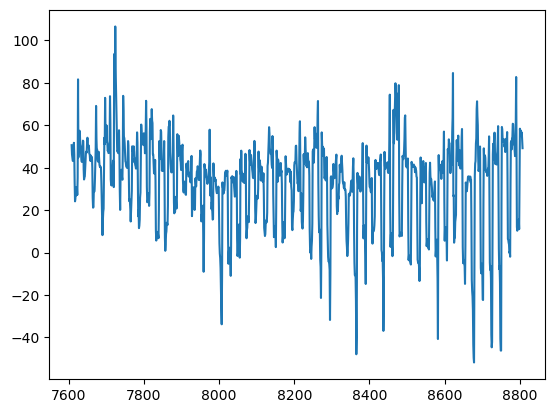

In [35]:
d_hourly.iloc[-1200:].price.plot()

## CNN3

In [39]:
TARGET_COL = "price"
COLS_TO_SCALE = ["price"]
FEATURES = ["price", "cos_h", "sin_h"]
HOURS_AHEAD = 3    # 👈 we will confirm from JSON
WINDOW = 41        # 👈 placeholder, will update from JSON
EPOCHS = 50        # we can increase later
LR = 0.001
BATCH_SIZE = 64

df=d_hourly.copy()
df["datetime"] = pd.to_datetime(df["timestamp"]).dt.tz_localize(None).dropna()
#df = df[FEATURES + [TARGET_COL]].dropna()

# Train: until mid 2021 / Validation until end 2021 / Test 2022
train = df[df.index < int(len(df)*0.7)]
vali  = df[(df.index >= int(len(df)*0.7)) & (df.index < int(len(df)*0.85))]
test  = df[df.index >= int(len(df)*0.85)]

# ------------------------ SCALE ---------------------------
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler().fit(train[COLS_TO_SCALE])
y_scaler = MinMaxScaler().fit(train[[TARGET_COL]])

def scale_df(d):
    d = d.copy()
    d[COLS_TO_SCALE] = x_scaler.transform(d[COLS_TO_SCALE])
    return d

train_s, vali_s, test_s = scale_df(train), scale_df(vali), scale_df(test)

# -------------------- WINDOW MAKING ------------------------
def load_windows(df_scaled, df_true, window, horizon):
    X, y = [], []
    for i in range(window, len(df_scaled)-horizon):
        X.append(df_scaled.iloc[i-window:i][FEATURES].values)
        y.append(df_true.iloc[i+horizon][TARGET_COL])
    return np.array(X), np.array(y)

X_train, y_train = load_windows(train_s, train, window=WINDOW, horizon=HOURS_AHEAD)
X_vali,  y_vali  = load_windows(vali_s,  vali,  window=WINDOW, horizon=HOURS_AHEAD)
X_test,  y_test  = load_windows(test_s,  test,  window=WINDOW, horizon=HOURS_AHEAD)

# --------------------- TO TENSORS --------------------------
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_vali,  y_vali  = torch.tensor(X_vali,  dtype=torch.float32), torch.tensor(y_vali,  dtype=torch.float32).unsqueeze(1)
X_test,  y_test  = torch.tensor(X_test,  dtype=torch.float32), torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
vali_loader  = DataLoader(TensorDataset(X_vali, y_vali), batch_size=BATCH_SIZE)

# ----------

In [13]:

# --------------------- MODEL CREATION -----------------------
# ⚠ parameters below will change once you paste JSON
model = model_dict["CNN"](in_dim=len(FEATURES), out_dim=1, window_size=WINDOW)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

# ------------------------ TRAINING --------------------------
best_val = float("inf")
for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        optimizer.step()

    # ---- validation ----
    model.eval()
    with torch.no_grad():
        val_loss = loss_fn(model(X_vali), y_vali).item()

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "cnn3_newdata.pt")  # save best

    print(f"Epoch {epoch+1}/{EPOCHS} ▸ Train Loss={loss.item():.4f} | Val={val_loss:.4f}")

print("\n✔ Training complete! Saved checkpoint → cnn3_new.pt")


Epoch 1/50 ▸ Train Loss=383.3478 | Val=247.0237
Epoch 2/50 ▸ Train Loss=466.9676 | Val=267.2699
Epoch 3/50 ▸ Train Loss=602.7859 | Val=249.0829
Epoch 4/50 ▸ Train Loss=631.3062 | Val=231.8710
Epoch 5/50 ▸ Train Loss=623.3568 | Val=248.8952
Epoch 6/50 ▸ Train Loss=443.8107 | Val=203.8713
Epoch 7/50 ▸ Train Loss=505.6909 | Val=174.3096
Epoch 8/50 ▸ Train Loss=470.4034 | Val=188.0479
Epoch 9/50 ▸ Train Loss=569.6669 | Val=147.4278
Epoch 10/50 ▸ Train Loss=264.4305 | Val=149.7670
Epoch 11/50 ▸ Train Loss=423.2852 | Val=156.2900
Epoch 12/50 ▸ Train Loss=573.8438 | Val=141.4097
Epoch 13/50 ▸ Train Loss=321.1135 | Val=134.8198
Epoch 14/50 ▸ Train Loss=606.7837 | Val=152.7274
Epoch 15/50 ▸ Train Loss=301.1846 | Val=147.2525
Epoch 16/50 ▸ Train Loss=225.3651 | Val=117.2494
Epoch 17/50 ▸ Train Loss=328.1247 | Val=132.9180
Epoch 18/50 ▸ Train Loss=479.2891 | Val=117.4988
Epoch 19/50 ▸ Train Loss=423.1835 | Val=176.2183
Epoch 20/50 ▸ Train Loss=218.8144 | Val=137.2843
Epoch 21/50 ▸ Train Loss=309.

In [14]:
# -------- LOAD BEST MODEL (already done) --------
model = model_dict["CNN"](in_dim=len(FEATURES), out_dim=1, window_size=WINDOW)

model.load_state_dict(torch.load("cnn3_newdata.pt", map_location=torch.device("cpu")))
model.eval()

# ---------------- PREDICT -----------------------
with torch.no_grad():
    y_hat = model(X_test).numpy().flatten()

y_pred = y_hat.copy() 
y_true = y_test.numpy().flatten()

def safe_mape(y_true, y_pred):
    mask = np.abs(y_true) > 1e-6
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def safe_mdape(y_true, y_pred):
    mask = np.abs(y_true) > 1e-6
    return np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
mae  = np.mean(np.abs(y_true - y_pred))
mape = safe_mape(y_true, y_pred)
mdape = safe_mdape(y_true, y_pred)

# R²
ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - np.mean(y_true))**2)
r2 = 1 - ss_res/ss_tot

print("\n📊 PERFORMANCE (Test Set, scaled back to $/MWh)")
print(f"RMSE  : {rmse:.3f}")
print(f"MAE   : {mae:.3f}")
print(f"MAPE  : {mape:.2f}%")
print(f"MdAPE : {mdape:.2f}%")
print(f"R²    : {r2:.3f}\n")



📊 PERFORMANCE (Test Set, scaled back to $/MWh)
RMSE  : 11.372
MAE   : 8.364
MAPE  : 108.09%
MdAPE : 18.74%
R²    : 0.694



In [15]:
d.price.describe()

count    105515.000000
mean         29.855924
std          34.404967
min        -103.469330
25%          17.286915
50%          33.187280
75%          44.684015
max         999.379200
Name: price, dtype: float64

In [17]:
d.loc[d.price>=0].price.describe()

count    90105.000000
mean        39.040449
std         27.389280
min          0.000000
25%         27.136490
50%         36.184040
75%         47.164130
max        999.379200
Name: price, dtype: float64

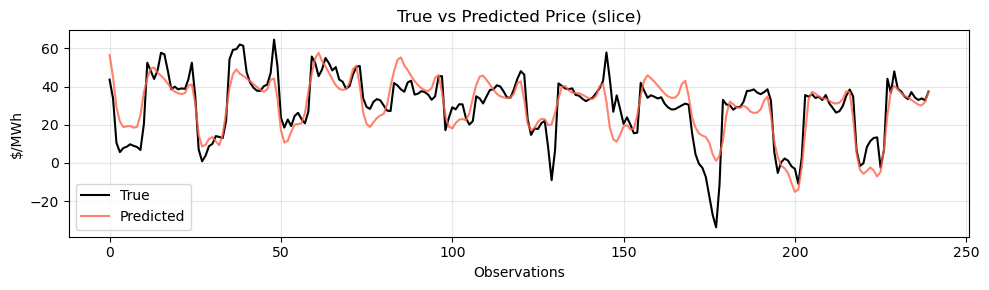

In [31]:
# ------------ QUICK LINE PLOT (change the slice) ------------
i0, i1 = 300, 300+24*10   # 👈 change slice here

plt.figure(figsize=(10,3))
plt.plot(y_true[i0:i1], label="True", color="black")
plt.plot(y_pred[i0:i1], label="Predicted", color="tomato", alpha=0.8)
plt.title("True vs Predicted Price (slice)")
plt.xlabel("Observations")
plt.ylabel("$/MWh")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [27]:
len(y_train)

6121

## XGBoost

In [42]:

df["price_lag3"]=df["price"].shift(3)
df["price_lag12"]=df["price"].shift(12)
df["price_lag24"]=df["price"].shift(24)

split = int(len(df)*0.8)
train_df = df.iloc[:split]
test_df  = df.iloc[split:]

feature_cols=["price_lag3",
              "price_lag12",
              "price_lag24", 'cos_h', 'sin_h']

model_ml = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=9,
    subsample=0.8,
    colsample_bytree=0.8
)
model_ml.fit(train_df[feature_cols], train_df["price"])

y_pred = model_ml.predict(test_df[feature_cols])
y_true = test_df["price"].values

# ---------- Metrics ----------
rmse  = np.sqrt(np.mean((y_true - y_pred)**2))
mae   = np.mean(np.abs(y_true - y_pred))

# Avoid divide by zero in MAPE
mask = np.abs(y_true) > 1e-6
mape  = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
mdape = np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]) * 100)

# Manual R² (same as sklearn)
ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - np.mean(y_true))**2)
r2_manual = 1 - ss_res / ss_tot

# ---------- Print ----------
print("📌 XGBoost Model Performance")
print(f"RMSE  : {rmse:.3f}")
print(f"MAE   : {mae:.3f}")
print(f"MAPE  : {mape:.2f}%")
print(f"MdAPE : {mdape:.2f}%")
print(f"R²    : {r2_manual:.3f}")

📌 XGBoost Model Performance
RMSE  : 11.606
MAE   : 7.871
MAPE  : 148.69%
MdAPE : 16.89%
R²    : 0.660
